In [142]:
using Revise, OrdinaryDiffEq, Flux, DiffEqFlux, Kinetic, Optim
using Plots, FileIO, JLD2, OffsetArrays, ProgressMeter

In [123]:
@load "X1d.jld2" X
@load "sol1d.jld2" ks ctr

2-element Array{Symbol,1}:
 :ks
 :ctr

In [129]:
vMeshType = "rectangle"
umin = ks.vSpace.u0; umax = ks.vSpace.u1; nu = ks.vSpace.nu
vmin = ks.vSpace.u0; vmax = ks.vSpace.u1; nv = 28
wmin = ks.vSpace.u0; wmax = ks.vSpace.u1; nw = 28
nm = 5; tLen = 2; nh = 12;

In [130]:
vSpace2D = VSpace2D(vmin, vmax, nv, wmin, wmax, nw, vMeshType)
vSpace3D = VSpace3D(umin, umax, nu, vmin, vmax, nv, wmin, wmax, nw, vMeshType)

kn_bzm = hs_boltz_kn(ks.gas.μᵣ, 1.0)
sos = sound_speed(ks.ib.primR, ks.gas.γ)
tmax = (ks.vSpace.u1 + sos) / ks.pSpace.dx[1]
dt = Float32(ks.set.cfl / tmax)
tspan = (0.f0, dt)
tran = range(tspan[1], tspan[2], length = tLen);

In [131]:
PRIM = zeros(Float32, 3, size(X, 2))
for i in axes(PRIM, 2)
    temp = moments_conserve(X[1:nu,i], X[nu+1:end,i], ks.vSpace.u, ks.vSpace.weights)
    PRIM[:,i] .= conserve_prim(temp, ks.gas.γ)
end

In [132]:
#--- Boltzmann dataset ---#
f_full = Array{Float32}(undef, nu, nv, nw, size(X, 2))
for i = 1:size(X, 2)
    f_full[:, :, :, i] .= full_distribution(
        X[1:nu, i],
        X[nu+1:end, i],
        ks.vSpace.u,
        ks.vSpace.weights,
        vSpace3D.v,
        vSpace3D.w,
        PRIM[:, i],
        ks.gas.γ,
    )
end

phi, psi, phipsi = kernel_mode(
    nm,
    vSpace3D.u1,
    vSpace3D.v1,
    vSpace3D.w1,
    vSpace3D.du[1, 1, 1],
    vSpace3D.dv[1, 1, 1],
    vSpace3D.dw[1, 1, 1],
    vSpace3D.nu,
    vSpace3D.nv,
    vSpace3D.nw,
    ks.gas.αᵣ,
)

function boltzmann(f, p, t)
    Kn, M, phi, psi, phipsi = p
    return boltzmann_fft(f[1:end,1:end,1:end], Kn, M, phi, psi, phipsi)
end

function boltzmann!(df, f, p, t)
    Kn, M, phi, psi, phipsi = p
    df .= boltzmann_fft(f, Kn, M, phi, psi, phipsi)
end

boltzmann! (generic function with 1 method)

In [133]:
data_boltz = zeros(Float32, nu, nv, nw, size(X, 2), tLen)
for i in axes(X, 2)
    prob = ODEProblem(
        boltzmann!,
        f_full[:, :, :, i],
        tspan,
        [kn_bzm, nm, phi, psi, phipsi],
    )

    #data_boltz[:, :, :, i, :] = solve(prob, Midpoint(), saveat=tran) |> Array # tLen > 2
    data_boltz[:, :, :, i, :] = solve(prob, Euler(), dt=dt) |> Array # tLen = 2
end

In [134]:
h_boltz = zeros(Float32, ks.vSpace.nu, size(X, 2), tLen)
b_boltz = zeros(Float32, ks.vSpace.nu, size(X, 2), tLen)
for j = 1:tLen, i in axes(X, 2)
    h_boltz[:, i, j], b_boltz[:, i, j] = reduce_distribution(
        data_boltz[:, :, :, i, j],
        vSpace3D.v,
        vSpace3D.w,
        vSpace2D.weights,
    )
end
Y = vcat(h_boltz, b_boltz);

In [135]:
#--- BGK dataset ---#
function bgk!(df, f, p, t)
    H, B, tau = p
    df[1:end÷2, :] .= (H .- f[1:end÷2, :]) ./ tau
    df[end÷2+1:end, :] .= (B .- f[end÷2+1:end, :]) ./ tau
end

#X = Array{Float32}(undef, nu * 2, ks.pSpace.nx)
#for i = 1:ks.pSpace.nx
#    X[1:nu, i] .= ctr[i].h
#    X[nu+1:end, i] .= ctr[i].b
#end

H = Array{Float32}(undef, nu, size(X, 2))
B = Array{Float32}(undef, nu, size(X, 2))
τ = Array{Float32}(undef, 1, size(X, 2))
for i in axes(X, 2)
    H[:, i] .= maxwellian(ks.vSpace.u, PRIM[:,i])
    B[:, i] .= H[:, i] .* ks.gas.K ./ (2.0 .* PRIM[end,i])
    τ[1, i] = vhs_collision_time(PRIM[:,i], ks.gas.μᵣ, ks.gas.ω)
end
P = [H, B, τ]

prob = ODEProblem(bgk!, X, tspan, P)
#Y1 = solve(prob, Midpoint(), saveat=tran) |> Array;
Y1 = solve(prob, Euler(), dt=dt) |> Array;

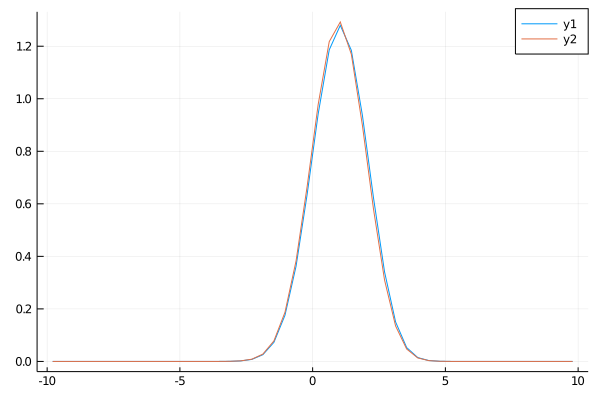

In [157]:
plot(ks.vSpace.u, Y[49:end,109,2])
plot!(ks.vSpace.u, Y1[49:end,109,2])

In [154]:
sum(abs2, Y1[:,:,2] .- Y[:,:,2])

0.69221884f0

In [197]:
#--- universal differential equation ---#
model_univ = FastChain(
    #(x, p) -> zeros(eltype(x), axes(x)),
    FastDense(nu * 2, nu * 2 * nh),
    #FastDense(ks.vSpace.nu * 2 * nh, ks.vSpace.nu * 2 * nh, tanh),
    FastDense(nu * 2 * nh, nu * 2),
    #(x, p) -> sum(x[1:nu] .* ks.vSpace.weights),
)

p_model = initial_params(model_univ)
#p_model .= 0.f0

function dfdt(f, p, t)
    h = f[1:nu, :]
    b = f[nu+1:end, :]

    dh = (H .- h) ./ τ .+ model_univ(f, p)[1:nu, :]
    db = (B .- b) ./ τ .+ model_univ(f, p)[nu+1:end, :]

    df = vcat(dh, db)
end

prob_ube = ODEProblem(dfdt, X, tspan, p_model)

function loss(p)
    #sol_ube = solve(prob_ube, Midpoint(), u0=X, p=p, saveat=tran)
    sol_ube = solve(prob_ube, Euler(), u0=X, p=p, dt=dt)
    loss = sum(abs2, Array(sol_ube) .- Y)
    #loss = sum(abs2, Array(sol_ube) .- Y1)
    return loss
end

cb = function (p, l)
    #display(l)
    return false
end

#95 (generic function with 1 method)

In [198]:
model_univ(X, p_model)

96×126 Array{Float32,2}:
  0.132071     0.132071     0.132071    …   0.131308     0.125512
  0.00655018   0.00655018   0.00655018     -0.0888007   -0.114256
 -0.106994    -0.106994    -0.106994       -0.190468    -0.214538
 -0.0128801   -0.0128801   -0.0128801      -0.0473862   -0.0524895
  0.122088     0.122088     0.122088        0.269849     0.305062
  0.113906     0.113906     0.113906    …   0.19781      0.215979
 -0.0402859   -0.0402859   -0.0402859      -0.122636    -0.155567
  0.0205147    0.0205147    0.0205147       0.0621138    0.0654497
 -0.0461713   -0.0461713   -0.0461713      -0.00407177   0.00353154
 -0.0215492   -0.0215492   -0.0215492      -0.0367799   -0.0430802
  0.0402291    0.0402291    0.0402291   …   0.0461676    0.041041
  0.164852     0.164852     0.164852        0.141211     0.127744
  0.0428528    0.0428528    0.0428528       0.14698      0.177057
  ⋮                                     ⋱                ⋮
  0.00398384   0.00398384   0.00398384      0.118233 

In [199]:
res = DiffEqFlux.sciml_train(loss, p_model, ADAM(), cb=Flux.throttle(cb, 1), maxiters=200)

loss: 1.21: 100%|█████████████████████████████████████████| Time: 0:00:09


 * Status: success

 * Candidate solution
    Final objective value:     1.205133e+00

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   14  (vs limit Inf)
    Iterations:    200
    f(x) calls:    200
    ∇f(x) calls:   200


In [202]:
res = DiffEqFlux.sciml_train(loss, res.minimizer, ADAM(), cb=Flux.throttle(cb, 1), maxiters=4000)

loss: 1.01: 100%|█████████████████████████████████████████| Time: 0:03:25


 * Status: success

 * Candidate solution
    Final objective value:     1.009887e+00

 * Found with
    Algorithm:     ADAM

 * Convergence measures
    |x - x'|               = NaN ≰ 0.0e+00
    |x - x'|/|x'|          = NaN ≰ 0.0e+00
    |f(x) - f(x')|         = NaN ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = NaN ≰ 0.0e+00
    |g(x)|                 = NaN ≰ 0.0e+00

 * Work counters
    Seconds run:   205  (vs limit Inf)
    Iterations:    4000
    f(x) calls:    4000
    ∇f(x) calls:   4000


In [107]:
function ube_rhs!(df, f, p, t)
    H = p[1:nu]
    B = p[nu+1:2*nu]
    τ = p[2*nu+1]
    p_nn = p[2*nu+2:end]

    h = f[1:nu]
    b = f[nu+1:end]

    dh = (H .- h) ./ τ .+ model_univ(f, p_nn)[1:nu]
    db = (B .- b) ./ τ .+ model_univ(f, p_nn)[nu+1:end]

    df[1:nu] .= dh
    df[nu+1:end] .= db
end

ube = ODEProblem(
    ube_rhs!,
    [ctr[1].h; ctr[1].b],
    tspan,
    [H[:, 1]; B[:, 1]; τ[1, 1]; res.minimizer],
);

In [108]:
function step_ube!(
    fwL,
    fhL,
    fbL,
    w,
    prim,
    h,
    b,
    fwR,
    fhR,
    fbR,
    K,
    γ,
    μ,
    ω,
    u,
    weights,
    p,
    dx,
    tran,
    RES,
    AVG,
)

    #--- record W^{n} ---#
    w_old = deepcopy(w)
    H = maxwellian(u, prim)
    B = H .* K ./ (2.0 .* prim[end])
    τ = vhs_collision_time(prim, μ, ω)
    
    #qf = heat_flux(h, b, prim, u, weights)
    #SH, SB = shakhov(u, H, B, qf, prim, ks.gas.Pr, K)
    
    #--- update W^{n+1} ---#
    @. w += (fwL - fwR) / dx
    prim .= conserve_prim(w, γ)

    #--- record residuals ---#
    @. RES += (w - w_old)^2
    @. AVG += abs(w)

    #--- update f^{n+1} ---#
    sol = solve(ube, Euler(), u0=[h; b], p=[H; B; τ; p], dt=dt)
    #sol = solve(ube, Midpoint(), u0=[h; b], p=[H; B; τ; p], saveat=tran)
    #sol = solve(ube, Midpoint(), u0=[h; b], p=[SH; SB; τ; p], saveat=tran)
    
    hstar = sol.u[end][1:length(h)]
    bstar = sol.u[end][length(h)+1:end]
    for i in eachindex(h)
        h[i] = hstar[i] + (fhL[i] - fhR[i]) / dx
        b[i] = bstar[i] + (fbL[i] - fbR[i]) / dx
    end

end

step_ube! (generic function with 1 method)

In [109]:
face = Array{Interface1D2F}(undef, ks.pSpace.nx + 1)
for i = 1:ks.pSpace.nx+1
    face[i] = Interface1D2F(ks.ib.wL, ks.ib.hL)
end

sumRes = zeros(Float32, axes(ks.ib.wL));
sumAvg = zeros(Float32, axes(ks.ib.wL));

In [116]:
@showprogress for iter = 1:50
    Kinetic.evolve!(ks, ctr, face, dt)

    for i = 2:49
        step_ube!(
            face[i].fw,
            face[i].fh,
            face[i].fb,
            ctr[i].w,
            ctr[i].prim,
            ctr[i].h,
            ctr[i].b,
            face[i+1].fw,
            face[i+1].fh,
            face[i+1].fb,
            ks.gas.K,
            ks.gas.γ,
            ks.gas.μᵣ,
            ks.gas.ω,
            ks.vSpace.u,
            ks.vSpace.weights,
            res.minimizer,
            ctr[i].dx,
            tran,
            sumRes,
            sumAvg,
        )
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


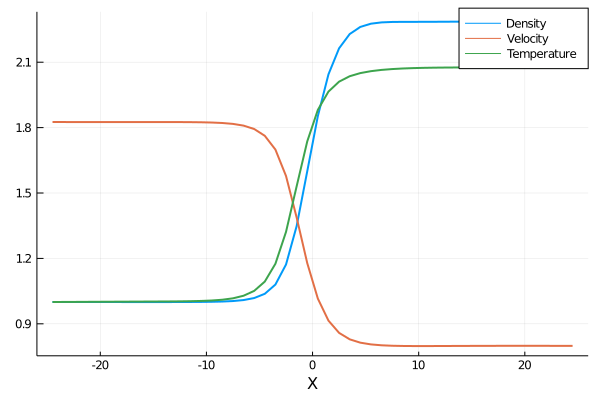

In [117]:
plot_line(ks, ctr)

In [119]:
res.minimizer

222432-element Array{Float32,1}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 -2.5518077f-8
  3.4163747f-9
 -1.3892699f-8
 -1.1128762f-8
 -1.8272543f-8
 -8.811153f-9
  1.0942358f-11
  1.9860977f-8
  1.5751217f-8
 -1.26088935f-8
 -3.9036063f-9
  6.4064984f-9